In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('demand_prediction.csv')
data.head()

,year,week,units_sold,population,shipping_costs,transportation_costs
0,2010,1,13344,5077000,74.69,46.55
1,2010,2,13651,5077000,15.28,35.19
2,2010,3,12798,5077000,46.33,14.39
3,2010,4,13341,5077000,58.22,23.75
4,2010,5,10581,5077400,86.31,58.90


---

### Predicting Demand: Uni-Variate Linear Regression Model

In [ ]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

Train Set	: (400, 1) (400, 1)
Test Set 	: (100, 1) (100, 1)


Intercept of Regression 	: b =  [-1978902.96960637]
Coefficients of Regression 	: a =  [[0.39193525]]



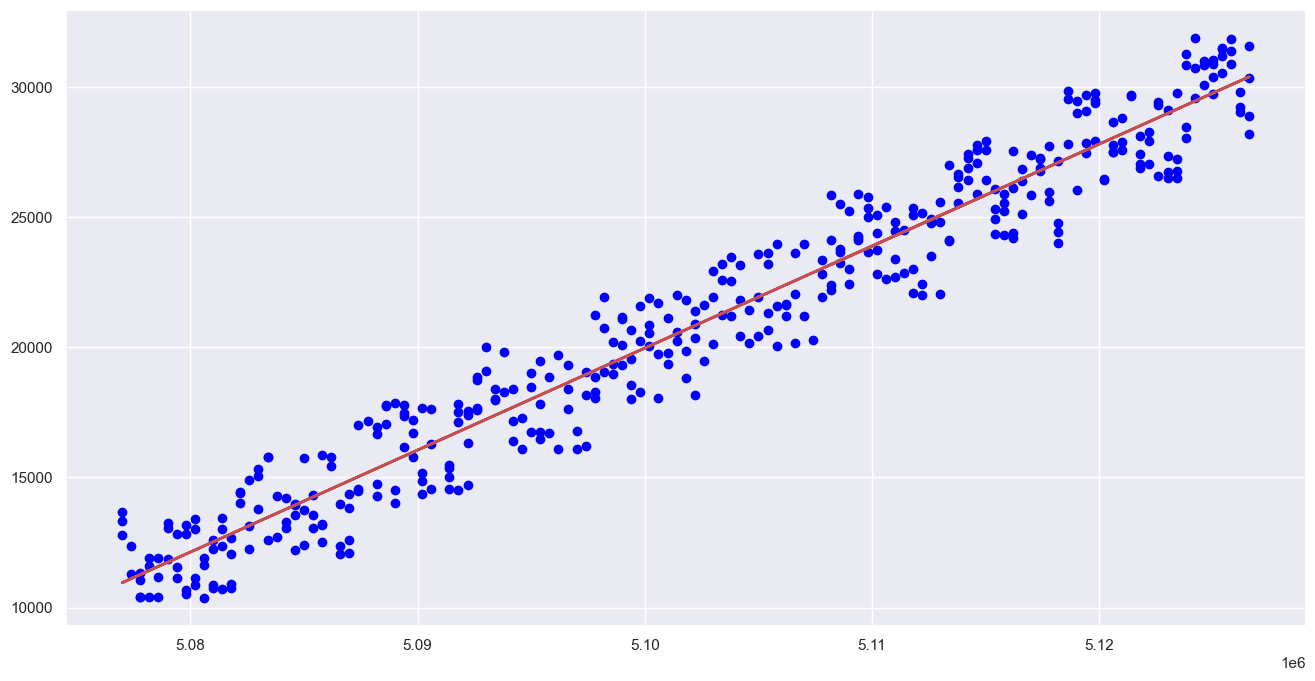

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9477799834150912
Mean Squared Error (MSE) 	: 1814426.559934959
Root Mean Squared Error (RMSE) 	: 1347.0065181486536

Prediction Accuracy 		Test Dataset
Explained Variance (R^2) 	: 0.930628074557384
Mean Squared Error (MSE) 	: 1863112.3449979543
Root Mean Squared Error (RMSE) 	: 1364.9587338077126


In [3]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Dataset
demand = pd.DataFrame(data['units_sold'])           # Response 
pop = pd.DataFrame(data['population'])              # Predictor

# Split the Dataset into Train and Test
pop_train, pop_test, demand_train, demand_test = train_test_split(pop, demand, test_size = 0.20)
print("Train Set\t:", pop_train.shape, demand_train.shape)
print("Test Set \t:", pop_test.shape, demand_test.shape)
print("\n")

# Linear Regression using Train Data
linreg = LinearRegression()                   # create the linear regression object
linreg.fit(pop_train, demand_train)           # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict SalePrice values corresponding to GrLivArea
demand_train_pred = linreg.predict(pop_train)
demand_test_pred = linreg.predict(pop_test)

# Plot the Predictions vs the True values
f = plt.figure(figsize=(16, 8))
plt.scatter(pop_train, demand_train, color = "blue")
plt.plot(pop_train, demand_train_pred, 'r-', linewidth = 2)
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(pop_train, demand_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(demand_train, demand_train_pred))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(demand_train, demand_train_pred)))

print()

# Check the Prediction Accuracy (on Test Data)
print("Prediction Accuracy \t\tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(pop_test, demand_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(demand_test, demand_test_pred))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(demand_test, demand_test_pred)))

---

### Optimise Logistics (Delivery): Capacitated Vehicles Routing Problem

In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [4]:
# Stores the data for the problem.
def create_data_model():
    data = {}
    data["distance_matrix"] = [
        # fmt: off
        [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
        [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
        [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
        [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
        [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
        [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
        [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
        [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
        [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
        [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
        [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
        [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
        [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
        [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
        [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
        [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
        [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ]
    data["demands"] = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]
    data["vehicle_capacities"] = [20, 10, 25, 30]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data


# Prints solution on console
def print_solution(data, manager, routing, solution):
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = data["vehicle_capacities"][vehicle_id]
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load -= data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")

In [6]:
# Solve the CVRP problem.
def main():
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


main()

Objective: 5092
Route for vehicle 0:
 0 Load(20) ->  0 Load(20)
Distance of the route: 0m
Load of the route: 20

Route for vehicle 1:
 0 Load(10) ->  7 Load(2) ->  0 Load(2)
Distance of the route: 388m
Load of the route: 2

Route for vehicle 2:
 0 Load(25) ->  1 Load(24) ->  4 Load(20) ->  3 Load(18) ->  15 Load(10) ->  11 Load(9) ->  12 Load(7) ->  13 Load(3) ->  0 Load(3)
Distance of the route: 2352m
Load of the route: 3

Route for vehicle 3:
 0 Load(30) ->  5 Load(28) ->  8 Load(20) ->  6 Load(16) ->  2 Load(15) ->  10 Load(13) ->  16 Load(5) ->  14 Load(1) ->  9 Load(0) ->  0 Load(0)
Distance of the route: 2352m
Load of the route: 0

Total distance of all routes: 5092m
Total load of all routes: 25


---

### Inventory Management

In [2]:
import numpy as np
from datetime import timedelta, date

In [15]:
# Initialize DataFrame
inventory_data = {
    'daily_demand_mean': [20],
    'daily_demand_std_dev': [5],
    'lead_time_days': [3],
    'service_level': [0.95],
    'shelf_life_days': [10],
}
inventory_df = pd.DataFrame(inventory_data)


def display_df():
    print("\nCurrent DataFrame:\n", inventory_df)

def add_row():
    ddm = float(input("Enter daily_demand_mean: "))
    ddsd = float(input("Enter daily_demand_std_dev: "))
    ltd = float(input("Enter lead_time_days: "))
    sl = float(input("Enter service_level: "))
    sld = float(input("Enter shelf_life_days: "))
    
    global inventory_df
    new_row = pd.DataFrame({'daily_demand_mean': [ddm], 
                            'daily_demand_std_dev': [ddsd], 
                            'lead_time_days': [ltd],
                            'service_level': [sl],
                            'shelf_life_days': [sld]})
    inventory_df = pd.concat([inventory_df, new_row], ignore_index=True)
    display_df()

def delete_row():
    global inventory_df
    try:
        index = int(input("Enter the index of the row to delete: "))
        
        if index in inventory_df.index:
            inventory_df = inventory_df.drop(index)
            display_df()
        else:
            print(f"No row at index {index}")
    except ValueError:
        print("Invalid input. Please enter a valid index.")

# Initial display of DataFrame
display_df()

# User input loop
while True:
    action = input("\nChoose an action: (1) Add Row (2) Delete Row (3) Select Row (4) Exit: ")
    
    if action == '1':
        add_row()
    elif action == '2':
        delete_row()
    elif action == '3':
        try:
            selected_row = int(input("Enter the index of the row to manage inventory: "))
            if selected_row in inventory_df.index:
                ddm_selected = inventory_df.loc[selected_row, 'daily_demand_mean']
                ddsd_selected = inventory_df.loc[selected_row, 'daily_demand_std_dev']
                ltd_selected = inventory_df.loc[selected_row, 'lead_time_days']
                sl_selected = inventory_df.loc[selected_row, 'service_level']
                sld_selected = inventory_df.loc[selected_row, 'shelf_life_days']
                
                print(f"Selected Row {selected_row} Values:")
                print(f"daily_demand_mean: {ddm_selected}")
                print(f"daily_demand_std_dev: {ddsd_selected}")
                print(f"lead_time_days: {ltd_selected}")
                print(f"service_level: {sl_selected}")
                print(f"shelf_life_days: {sld_selected}")
            else:
                print(f"No row at index {selected_row}")
        except ValueError:
            print("Invalid input. Please enter a valid index.")
    elif action == '4':
        print("Exiting...")
        break
    else:
        print("Invalid choice. Please try again.")


Current DataFrame:
    daily_demand_mean  daily_demand_std_dev  lead_time_days  service_level  \
0                 20                     5               3           0.95   

   shelf_life_days  
0               10  

Choose an action: (1) Add Row (2) Delete Row (3) Select Row (4) Exit: 2
Enter the index of the row to delete: 0

Current DataFrame:
 Empty DataFrame
Columns: [daily_demand_mean, daily_demand_std_dev, lead_time_days, service_level, shelf_life_days]
Index: []

Choose an action: (1) Add Row (2) Delete Row (3) Select Row (4) Exit: 1
Enter daily_demand_mean: 1
Enter daily_demand_std_dev: 2
Enter lead_time_days: 3
Enter service_level: 4
Enter shelf_life_days: 5

Current DataFrame:
    daily_demand_mean  daily_demand_std_dev  lead_time_days  service_level  \
0                1.0                   2.0             3.0            4.0   

   shelf_life_days  
0              5.0  

Choose an action: (1) Add Row (2) Delete Row (3) Select Row (4) Exit: 1
Enter daily_demand_mean: 2
Ent

In [16]:
# Function to calculate safety stock
def calculate_safety_stock(ddsd_selected, ltd_selected, sl_selected):
    z_score = np.abs(np.round(np.random.normal(loc=0, scale=1, size=100000)).mean() * sl_selected)
    safety_stock = z_score * ddsd_selected * np.sqrt(ltd_selected)
    return safety_stock

# Calculate average lead time demand
lead_time_demand = ddm_selected * ltd_selected

# Calculate safety stock
safety_stock = calculate_safety_stock(ddsd_selected, ltd_selected, sl_selected)
print(f"Safety Stock: {safety_stock:.2f} units")

# Calculate reorder point
reorder_point = ltd_selected + safety_stock
print(f"Reorder Point: {reorder_point:.2f} units")

# Inventory management function to decide when to order
def manage_inventory(current_inventory, expiry_dates):
    # Remove expired items
    today = date.today()
    valid_inventory = [(qty, exp_date) for qty, exp_date in expiry_dates if exp_date > today]
    total_inventory = sum(qty for qty, exp_date in valid_inventory)
    
    # Check if it's time to reorder
    if total_inventory <= reorder_point:
        order_quantity = reorder_point - total_inventory + ddm_selected * ltd_selected
        return order_quantity, today + timedelta(days=shelf_life_days)
    return 0, None

# Example usage:
current_inventory = 50  # Current inventory level
expiry_dates = [(30, date(2024, 6, 15)), (20, date(2024, 6, 10))]  # Example inventory with expiry dates

order_quantity, expiry_date = manage_inventory(current_inventory, expiry_dates)
print(f"Order Quantity: {order_quantity:.2f} units, Expiry Date: {expiry_date}")


Safety Stock: 0.04 units
Reorder Point: 4.04 units
Order Quantity: 0.00 units, Expiry Date: None
